## Import necessary functions

In [927]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

## Generate the true function.
We will be using $f(x)=\sin(x)$ with noisy samples.

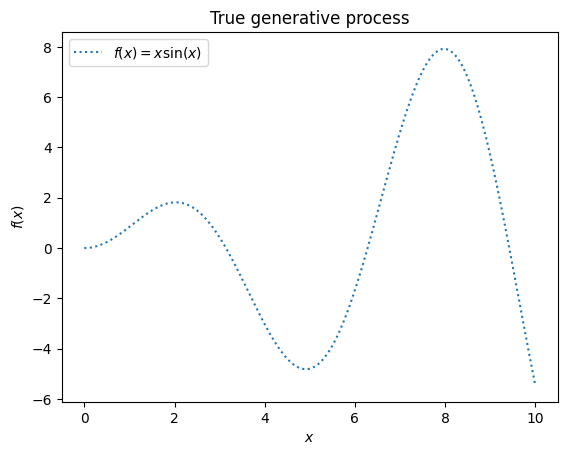

In [928]:
def f(x):
    return x * np.sin(x)

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(f(X))

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

### Generate noisy samples

In [929]:
rng = np.random.RandomState(1)
noise_std = 0.25
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

## Produce the model

In [930]:
kernel = RBF(length_scale_bounds=(1e-10,1e10)) + ConstantKernel()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train_noisy)
gaussian_process.kernel_

RBF(length_scale=0.667) + 0.332**2

## Make predictions and calculate loss

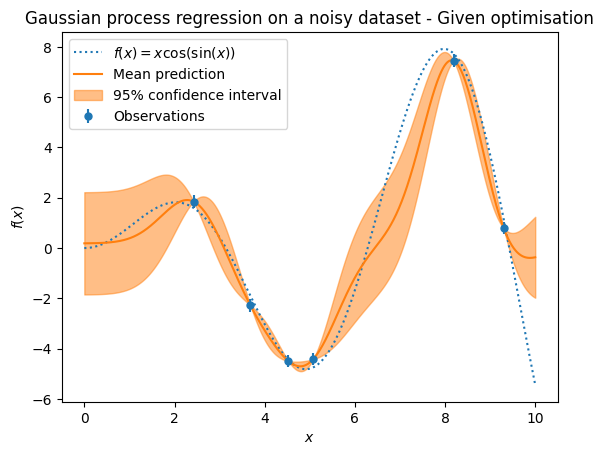

In [931]:
mean_prediction_unoptimised, std_prediction_unoptimised = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \cos(\sin(x))$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction_unoptimised, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction_unoptimised - 1.96 * std_prediction_unoptimised,
    mean_prediction_unoptimised + 1.96 * std_prediction_unoptimised,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset - Given optimisation")
plt.savefig('Data\\Hyperparameter_unoptimised.png')

In [932]:
def mean_squared_error(model, inp, expected):
    predictions = model.predict(inp)
    return ((expected - predictions) ** 2).mean(axis=None)


In [933]:
error = mean_squared_error(gaussian_process, X, y)
print(f'The loss of {gaussian_process.kernel_} is: \n\t{error}')

The loss of RBF(length_scale=0.667) + 0.332**2 is: 
	1.4609275261354533


In [934]:
from tqdm.notebook import tqdm

def random_search(model_type, kernel, bounds):
    param_limits = dict()
    for param, value in kernel.get_params().items():
        if type(value) == type(1.0):
            param_limits[param] = (1, 0.5)
        if type(value) == type((1,1)):
            kernel.set_params(**{param: bounds})

    min_loss = float('inf')
    loss_prev_epoch = float('inf')
    size = 10
    for j in (epoch_bar := tqdm(range(10))):
        epoch_bar.set_description(f'Current loss: {min_loss}')
        distributions = None
        params = []

        for param, value in kernel.get_params().items():
            if type(value) == type(1.0) or type(value) == np.float64:
                mean, std = param_limits[param]
                distribution = np.random.normal(loc=mean, scale=std, size=size)
                distribution = np.clip(distribution, bounds[0], bounds[1])
                params.append(param)
                if distributions is None:
                    distributions = distribution
                else:
                    distributions = np.vstack((distributions, distribution))

        XY = np.meshgrid(*tuple(distributions))

        mat = np.array(XY).transpose()

        coords = mat.shape[-1]

        mat = mat.reshape(-1, coords)

        for i in mat:
            parameters = {param: val for param, val in zip(params, i)}
            kernel.set_params(**parameters)
            test_model = model_type(kernel=kernel, optimizer=None)
            test_model.fit(X_train, y_train_noisy)
            error = mean_squared_error(test_model, X, y)
            if error < min_loss:
                min_loss = error
                stored_params = parameters
        for param, value in stored_params.items():
            if loss_prev_epoch == min_loss:
                param_limits[param] = (value, param_limits[param][1] * 1.5)
            else:
                param_limits[param] = (value, value / 2)
        kernel.set_params(**stored_params)
        loss_prev_epoch = min_loss
    return kernel, min_loss

In [1]:
custom_kernel, loss = random_search(GaussianProcessRegressor, RBF(), (1e-10,1e10))
loss

NameError: name 'random_search' is not defined

In [ ]:
custom_model = GaussianProcessRegressor(kernel=custom_kernel, optimizer=None)
custom_model.fit(X_train, y_train_noisy)

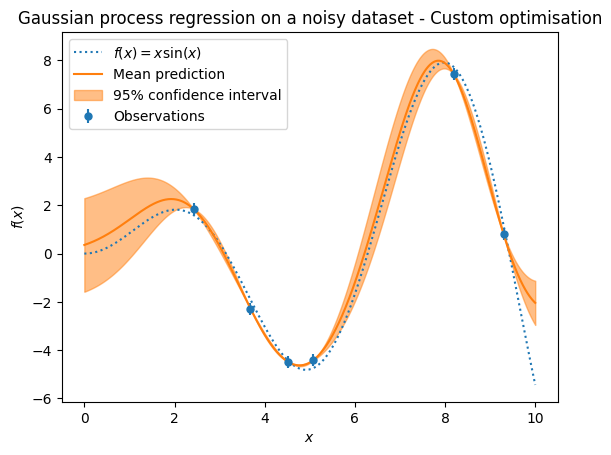

In [937]:
mean_prediction_optimised, std_prediction_optimised = custom_model.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction_optimised, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction_optimised - 1.96 * std_prediction_optimised,
    mean_prediction_optimised + 1.96 * std_prediction_optimised,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset - Custom optimisation")
plt.savefig('Data\\Hyperparameter_optimised.png')

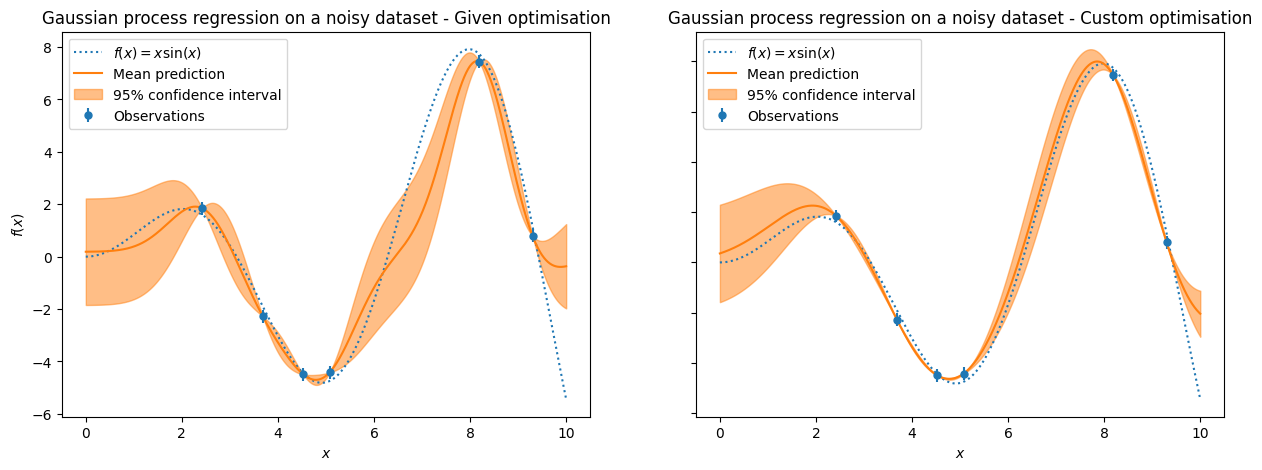

In [938]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
ax1.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
ax1.plot(X, mean_prediction_unoptimised, label="Mean prediction")
ax1.fill_between(
    X.ravel(),
    mean_prediction_unoptimised - 1.96 * std_prediction_unoptimised,
    mean_prediction_unoptimised + 1.96 * std_prediction_unoptimised,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax1.legend()
ax1.set(xlabel='$x$', ylabel='$f(x)$')
ax1.set_title("Gaussian process regression on a noisy dataset - Given optimisation")

ax2.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
ax2.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
ax2.plot(X, mean_prediction_optimised, label="Mean prediction")
ax2.fill_between(
    X.ravel(),
    mean_prediction_optimised - 1.96 * std_prediction_optimised,
    mean_prediction_optimised + 1.96 * std_prediction_optimised,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax2.legend()
ax2.set(xlabel='$x$', ylabel='$f(x)$')
ax2.set_title("Gaussian process regression on a noisy dataset - Custom optimisation")

for ax in [ax1, ax2]:
    ax.label_outer()

fig.savefig('Hyperparameter.png')